In [176]:
!jupyter nbextension enable --py widgetsnbextension
from clickhouse_driver import Client

import pandas as pd
import numpy as np

from datetime import date, timedelta
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import scikitplot as skplt
import sklearn
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## 1. Загружаем чеки

In [13]:
## собираем чеки
select = """
SELECT    
    checks.db_name as db_name, 
    db.date_reg as date_reg,
    case when db.date_reg  > today() - 60 then 1 else 0 end as flag_is_new_reg,
    case when end_date < today() +180  then 1 else 0 end as flag_is_finished_check,
    subs_plan_sales, 
    db_apply_date,
    db_apply_date_time,
    end_date,
    end_week1,
    w1.hit_cnt as w1_hit_cnt,
    w1.user_cnt as w1_user_cnt,
    w1.day_cnt as w1_day_cnt,
    end_week2,
    w2.hit_cnt as w2_hit_cnt,
    w2.user_cnt as w2_user_cnt,
    w2.day_cnt as w2_day_cnt,
    end_week3,
    w3.hit_cnt as w3_hit_cnt,
    w3.user_cnt as w3_user_cnt,
    w3.day_cnt as w3_day_cnt,
    end_week4,
    w4.hit_cnt as w4_hit_cnt,
    w4.user_cnt as w4_user_cnt,
    w4.day_cnt as w4_day_cnt,
    end_week5,
    w5.hit_cnt as w5_hit_cnt,
    w5.user_cnt as w5_user_cnt,
    w5.day_cnt as w5_day_cnt,
    end_week6,
    w6.hit_cnt as w6_hit_cnt,
    w6.user_cnt as w6_user_cnt,
    w6.day_cnt as w6_day_cnt,
    end_week7,
    w7.hit_cnt as w7_hit_cnt,
    w7.user_cnt as w7_user_cnt,
    w7.day_cnt as w7_day_cnt,
    end_week8,
    w8.hit_cnt as w8_hit_cnt,
    w8.user_cnt as w8_user_cnt,
    w8.day_cnt as w8_day_cnt,
    end_date - db_apply_date as check_range,
    period,
	db_apply_date - db.date_reg  as lt_to_apply, 
    billing_region,
    check_channel,
    partner_id,
    discount,
    buyer_status_mrr,
    buyer_status,
    check_id,
    smID,
    tariff_table.tariffActiveTo AS tariffActiveTo,
    tariff_table.tariff AS tariff
    FROM 
  	(
   		select
		    db_name, 
		    b24_date_reg,
		    subs_plan_sales2 as subs_plan_sales, 
            db_apply_date_time,
		    db_apply_date,
		    end_date2 as end_date,
            toStartOfWeek(least(end_date2,toDate('2022-11-07')), 1) as end_week1,
		    date_add(week, -1, end_week1) as end_week2,
		    date_add(week, -2, end_week1) as end_week3,
		    date_add(week, -3, end_week1) as end_week4,
		    date_add(week, -4, end_week1) as end_week5,
		    date_add(week, -5, end_week1) as end_week6,
		    date_add(week, -6, end_week1) as end_week7,
		    date_add(week, -7, end_week1) as end_week8,
		    end_date - db_apply_date as check_range,
		    period,
		    region2 as billing_region,
		    check_channel,
		    partner_id,
		    discount,
		    buyer_status_mrr,
		    buyer_status,
		    check_id
		    FROM b24stat.BI_check_all
		    WHERE action = 'B24' AND order_canceled != 'Y' AND order_item_price > 0
			AND db_name <> '' AND region2 = 'RU' 
	) as checks
	ANY LEFT JOIN b24stat.BI_db as db on checks.db_name = db.db_name
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w1 on checks.db_name = w1.db_name AND checks.end_week1 = w1.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w2 on checks.db_name = w2.db_name AND checks.end_week2 = w2.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w3 on checks.db_name = w3.db_name AND checks.end_week3 = w3.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w4 on checks.db_name = w4.db_name AND checks.end_week4 = w4.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w5 on checks.db_name = w5.db_name AND checks.end_week5 = w5.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w6 on checks.db_name = w6.db_name AND checks.end_week6 = w6.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w7 on checks.db_name = w7.db_name AND checks.end_week7 = w7.week
	ANY LEFT JOIN b24stat.BI_active_week_source_agr as w8 on checks.db_name = w8.db_name AND checks.end_week8 = w8.week
	ANY LEFT JOIN 
(
	SELECT dbName,
	argMax(tariffActiveTo , tariffActiveFrom) AS tariffActiveTo,
	argMax(tariff , tariffActiveFrom) AS tariff
	FROM
		(SELECT * 
		FROM b24stat.b24Tariff  WHERE tariff NOT LIKE '%project' AND tariff NOT LIKE '%nfr' 
		AND tariff NOT LIKE '%demo' AND tariff NOT LIKE '%vacation' AND tariff NOT LIKE '%alive' AND tariff NOT LIKE '%edu')
	GROUP BY dbName
) AS tariff_table
on checks.db_name = tariff_table.dbName
"""

In [16]:
client = Client(host='XXX',port=9000,user='XXX',password='XXX',database='XXX', verify=False, compression='lz4')
result, columns = client.execute(select, with_column_types=True)
df_checks = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])
df_checks.shape

(657205, 53)

In [371]:
#Добавляем поле check_number_by_portal - это номер чека в портале который мы вычисляем по порядку
df_checks['check_number_by_portal'] = df_checks.groupby(by=['db_name'])['db_apply_date_time'].transform(lambda x: x.rank(ascending=True))

In [372]:
#Добавляем следующий ключ и текущий для последующей проверки наличия покупки совершеннай после этого чека
df_checks['next_key'] = df_checks['db_name'] + '_' + (df_checks['check_number_by_portal'] + 1).astype('int').astype('str')
df_checks['this_key'] = df_checks['db_name'] + '_' + df_checks['check_number_by_portal'].astype('int').astype('str')

In [373]:
#мерджим таблицу Саму на себя по текущему ключу и следующему
#ТЕ проверяем наличие покупки чека совершенной после текушего чека
df_checks = df_checks.merge(df_checks, left_on = 'next_key', right_on = 'this_key', suffixes=('', '_next'), how='left')

# убираем все дублирующие и ненужные поля после мерджа
df_checks = df_checks[[
                    'db_name', 'db_apply_date', 'end_date', 'subs_plan_sales', 'check_number_by_portal', 
                    'check_number_by_portal_next', 'check_range','billing_region', 'lt_to_apply', 'check_channel', 
                    'partner_id', 'buyer_status_mrr','flag_is_new_reg', 'discount', 'period', 'buyer_status', 'check_id',
                    'w1_hit_cnt', 'w1_user_cnt', 'w1_day_cnt', 'flag_is_finished_check',
                    'w2_hit_cnt', 'w2_user_cnt', 'w2_day_cnt', 
                    'w3_hit_cnt', 'w3_user_cnt', 'w3_day_cnt', 
                    'w4_hit_cnt', 'w4_user_cnt', 'w4_day_cnt', 
                    'w5_hit_cnt', 'w5_user_cnt', 'w5_day_cnt', 
                    'w6_hit_cnt', 'w6_user_cnt', 'w6_day_cnt', 
                    'w7_hit_cnt', 'w7_user_cnt', 'w7_day_cnt', 
                    'w8_hit_cnt', 'w8_user_cnt', 'w8_day_cnt'
                      ]]

In [374]:
df_checks['w1_hit_per_user_cnt'] = df_checks['w1_hit_cnt']/df_checks['w1_user_cnt']
df_checks['w2_hit_per_user_cnt'] = df_checks['w2_hit_cnt']/df_checks['w2_user_cnt']
df_checks['w3_hit_per_user_cnt'] = df_checks['w3_hit_cnt']/df_checks['w3_user_cnt']
df_checks['w4_hit_per_user_cnt'] = df_checks['w4_hit_cnt']/df_checks['w4_user_cnt']
df_checks['w5_hit_per_user_cnt'] = df_checks['w5_hit_cnt']/df_checks['w5_user_cnt']
df_checks['w6_hit_per_user_cnt'] = df_checks['w6_hit_cnt']/df_checks['w6_user_cnt']
df_checks['w7_hit_per_user_cnt'] = df_checks['w7_hit_cnt']/df_checks['w7_user_cnt']
df_checks['w8_hit_per_user_cnt'] = df_checks['w8_hit_cnt']/df_checks['w8_user_cnt']

In [375]:
df_checks.query('db_name  == "b13794802"').sort_values(by='check_number_by_portal', ascending=False)

db_name db_apply_date   end_date subs_plan_sales  \
72805   b13794802    2022-07-04 2023-07-12    Professional   
425987  b13794802    2021-11-12 2022-07-12    Professional   
141300  b13794802    2021-11-12 2022-04-12    Professional   
340241  b13794802    2021-11-12 2022-01-12    Professional   
57890   b13794802    2021-11-12 2021-12-12    Professional   
66762   b13794802    2021-06-30 2021-11-14        Standard   
351777  b13794802    2021-06-30 2021-10-14        Standard   
312240  b13794802    2021-06-30 2021-09-14        Standard   
604302  b13794802    2021-06-30 2021-08-14        Standard   
445222  b13794802    2021-01-14 2021-07-14        Standard   
79459   b13794802    2021-01-14 2021-04-14        Standard   
429572  b13794802    2020-09-02 2021-01-14        Standard   
573183  b13794802    2020-05-27 2021-05-27           Basic   

        check_number_by_portal  check_number_by_portal_next  check_range  \
72805                     13.0                          NaN          373   
425987                    12.0                         13.0          242   
141300                    11.0                         12.0          151   
340241                    10.0                         11.0           61   
57890                      9.0                         10.0           30   
66762                      8.0                          9.0          137   
351777                     7.0                          8.0          106   
312240                     6.0                          7.0           76   
604302                     5.0                          6.0           45   
445222                     4.0                          5.0          181   
79459                      3.0                          4.0           90   
429572                     2.0                          3.0          134   
573183                     1.0                          2.0          365   

       billing_region  lt_to_apply check_channel  partner_id buyer_status_mrr  \
72805              RU          800       partner    10429330          Renewal   
425987             RU          566       partner    10429330          Renewal   
141300             RU          566       partner    10429330          Renewal   
340241             RU          566       partner    10429330          Renewal   
57890              RU          566       partner    10429330          Renewal   
66762              RU          431       partner    10429330          Renewal   
351777             RU          431       partner    10429330          Renewal   
312240             RU          431       partner    10429330          Renewal   
604302             RU          431       partner    10429330          Renewal   
445222             RU          264       partner    10429330          Renewal   
79459              RU          264       partner    10429330          Renewal   
429572             RU          130       partner    10429330          Renewal   
573183             RU           32       partner    10429330              New   

        flag_is_new_reg  discount  period buyer_status  check_id  w1_hit_cnt  \
72805                 0         0      12      Renewal  13201822      856371   
425987                0         0       3      Renewal  11891176      837182   
141300                0         0       3      Renewal  11891178      546357   
340241                0         0       1      Renewal  11891180      394277   
57890                 0         0       1      Upgrade  11891182      392613   
66762                 0         0       1      Renewal  11221994      265601   
351777                0         0       1      Renewal  11221992      274859   
312240                0         0       1      Renewal  11221990      242345   
604302                0         0       1      Renewal  11221988      133412   
445222                0         0       3      Renewal  10373516      117917   
79459                 0         0       3      Renewal  10373

In [376]:
#добавляем флаг is_last - была ли это последний чек на портале?
df_checks.loc[df_checks['check_number_by_portal_next'].isnull(), 'flag_is_churn'] = 1
df_checks.loc[df_checks['check_number_by_portal_next'].notnull(), 'flag_is_churn'] = 0
df_checks = df_checks.drop(['check_number_by_portal_next'], axis=1)

In [377]:
# уберем чеки по которым мы не будем делать предсказание
# df_checks = df_checks.query("""flag_is_new_reg == 0""").query("""flag_is_finished_check == 1""")
df_checks = df_checks.query("""flag_is_new_reg == 0""")

In [383]:
# посмотрим на границу интервала для прогноза
print(df_checks.db_apply_date.max())
print(df_checks.db_apply_date.min())
print(df_checks.end_date.max())

2023-02-27 00:00:00
1970-01-01 00:00:00
2041-06-04 00:00:00


## 2. Изучим данные и уберем лишнее

In [384]:
# проверяем откуда отрицательные значения в длине чека
# после того как посмотрели полную статку в бд, видим что это чеки которые были куплены но не сразу применены.
df_checks.query('check_range <= 0').shape

(198, 50)

In [385]:
# так как значений этих мало, просто избавимся от них
df_checks = df_checks.query('check_range >= 0')

In [386]:
# уберем чеки которые были применены ранее даты регистрации, какая-то ошибка и погрешность
df_checks.query('lt_to_apply < 0').shape

(174, 50)

In [388]:
#Посмотрим распределение по предсказываемому флагу последний ли это чек или портал ещё продляет?
df_checks['flag_is_churn'].value_counts()

0.0    556952
1.0     98236
Name: flag_is_churn, dtype: int64

In [389]:
df_checks['flag_is_churn'].sum() * 100 / df_checks.shape[0]

14.993559100594029

In [390]:
# посмотрим распределение по странам
df_checks.groupby('billing_region')['flag_is_churn'].sum() * 100 / df_checks.groupby('billing_region')['flag_is_churn'].count()

billing_region
RU    14.993559
Name: flag_is_churn, dtype: float64

In [393]:
df_checks['subs_plan_sales'].value_counts()

Basic           341466
Standard        203076
Professional     87767
Other            22599
Enterprise         280
Name: subs_plan_sales, dtype: int64

In [394]:
# уберем непонятные тарифы из Other, это всякое старье
df_checks = df_checks.query('subs_plan_sales in ("Standard", "Professional", "Enterprise")')
df_checks.shape

(291123, 50)

In [395]:
df_checks['subs_plan_sales'].value_counts()

Standard        203076
Professional     87767
Enterprise         280
Name: subs_plan_sales, dtype: int64

In [396]:
# посмотрим распределение по subs_plan_sales
df_checks.groupby('subs_plan_sales')['flag_is_churn'].sum() * 100 / df_checks.groupby('subs_plan_sales')['flag_is_churn'].count()

subs_plan_sales
Enterprise      71.428571
Professional    16.948284
Standard        14.821052
Name: flag_is_churn, dtype: float64

In [399]:
# уберем непонятные тарифы из Other, это всякое старье
df_checks = df_checks.query('period in (6, 12, 24)')
df_checks.shape

(60121, 50)

In [400]:
df_checks['period'].value_counts()

12    49985
6      8108
24     2028
Name: period, dtype: int64

In [401]:
#
df_checks = df_checks.drop([
                             'w1_hit_cnt', 'w2_hit_cnt','w3_hit_cnt', 'w4_hit_cnt', 
                             'w5_hit_cnt', 'w6_hit_cnt','w7_hit_cnt', 'w8_hit_cnt',
                             'flag_is_new_reg', 
                             'discount', 'buyer_status', 'flag_is_finished_check'
                                                                    ], axis=1)

In [402]:
df_checks = df_checks.set_index('check_id')

In [403]:
df_checks.describe()

check_number_by_portal   check_range   lt_to_apply    partner_id  \
count            60121.000000  60121.000000  60121.000000  6.012100e+04   
mean                 5.073053    374.296718    740.616706  3.320654e+06   
std                  6.263088    111.223593    724.346393  4.285527e+06   
min                  1.000000    104.000000      0.000000  0.000000e+00   
25%                  1.000000    365.000000    116.000000  2.209800e+04   
50%                  3.000000    368.000000    528.000000  7.520650e+05   
75%                  6.000000    385.000000   1134.000000  6.721359e+06   
max                 86.000000   1726.000000   3894.000000  1.722452e+07   

             period   w1_user_cnt    w1_day_cnt   w2_user_cnt    w2_day_cnt  \
count  60121.000000  60121.000000  60121.000000  60121.000000  60121.000000   
mean      11.595616     21.532193      4.810432     21.241263      4.734203   
std        3.090153     47.873476      3.013224     47.812594      3.020590   
min        6.000000      0.000000      0.000000      0.000000      0.000000   
25%       12.000000      0.000000      0.000000      0.000000      0.000000   
50%       12.000000      8.000000      7.000000      8.000000      7.000000   
75%       12.000000     22.000000      7.000000     22.000000      7.000000   
max       24.000000   2396.000000      7.000000   2620.000000      7.000000   

        w3_user_cnt    w3_day_cnt   w4_user_cnt    w4_day_cnt   w5_user_cnt  \
count  60121.000000  60121.000000  60121.000000  60121.000000  60121.000000   
mean      21.209710      4.776185     20.997771      4.733887     20.884915   
std       47.969525      3.034176     47.419101      3.043058     51.203083   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        8.000000      7.000000      8.000000      7.000000      8.000000   
75%       22.000000      7.000000     22.000000      7.000000     22.000000   
max     2495.000000      7.000000   2731.000000      7.000000   5587.000000   

         w5_day_cnt   w6_user_cnt    w6_day_cnt   w7_user_cnt    w7_day_cnt  \
count  60121.000000  60121.000000  60121.000000  60121.000000  60121.000000   
mean       4.716987     20.830808      4.698841     20.642621      4.681625   
std        3.047041     52.117069      3.061607     51.998716      3.069805   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        7.000000      8.000000      7.000000      8.000000      7.000000   
75%        7.000000     21.000000      7.000000     21.000000      7.000000   
max        7.000000   5772.000000      7.000000   5753.000000      7.000000   

        w8_user_cnt    w8_day_cnt  w1_hit_per_user_cnt  w2_hit_per_user_cnt  \
count  60121.000000  60121.000000         44573.000000         44296.000000   
mean      20.523278      4.666057          1271.004524          1166.099606   
std       51.772246      3.075552          1846.715824          1704.514138   
min        0.000000      0.000000             1.000000             1.000000   
25%        0.000000      0.000000           244.200000           223.899687   
50%        8.000000      7.000000           642.714286           586.390756   
75%       21.000000      7.000000          1554.750000          1424.510246   
max     5832.000000      7.000000         75527.070175         50754.000000   

       w3_hit_per_user_cnt  w4_hit_per_user_cnt  w5_hit_per_user_cnt  \
count         44180.000000         43940.000000         43802.000000   
mean           1254.721694          1244.514442          1212.986706   
std            1799.018862          1806.185573          1748.574665   
min               1.000000             1.000000             1.000000   
25%             235.160714           227.714286           227.007246   
50%             625.714286           615.333333    

In [404]:
# важное замечание!
# я пытался все эти фичи чистить от выбросов, отрезать длинный хвост распределения, чтобы выровнять. 
# Точно прогноза всегда становилась только хуже. Поэтому в финальной версии нет чистки данных

In [405]:
# в итоге у нас есть довольно похожие метрики по неделям, но многочисленные эксперименты показали
#, что убирая лишние показатели мы только ухудшаем прогноз

## 3. CATBOOST DATA Preparation

In [406]:
# посмотрим где у нас NULL
null_value_stats = df_checks.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

w1_hit_per_user_cnt    15548
w2_hit_per_user_cnt    15825
w3_hit_per_user_cnt    15941
w4_hit_per_user_cnt    16181
w5_hit_per_user_cnt    16319
w6_hit_per_user_cnt    16608
w7_hit_per_user_cnt    16772
w8_hit_per_user_cnt    16912
dtype: int64

In [407]:
# заменим NULL на 0
df_checks = df_checks.fillna(0)
null_value_stats = df_checks.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

## 3.1 Подготовим train_df

In [416]:
train_df = df_checks.copy()

In [417]:
train_df.head().T

check_id                           10465566             13157754  \
db_name                            b9114649            b13768882   
db_apply_date           2021-02-02 00:00:00  2022-06-28 00:00:00   
end_date                2022-02-14 00:00:00  2023-07-06 00:00:00   
subs_plan_sales                Professional             Standard   
check_number_by_portal                  3.0                  3.0   
check_range                             377                  373   
billing_region                           RU                   RU   
lt_to_apply                             783                  796   
check_channel                       partner              partner   
partner_id                          7847719              9449029   
buyer_status_mrr                    Renewal              Renewal   
period                                   12                   12   
w1_user_cnt                              79                   27   
w1_day_cnt                                7                    7   
w2_user_cnt                              83                   25   
w2_day_cnt                                6                    7   
w3_user_cnt                              87                   25   
w3_day_cnt                                7                    7   
w4_user_cnt                              81                   31   
w4_day_cnt                                7                    7   
w5_user_cnt                              79                   32   
w5_day_cnt                                7                    7   
w6_user_cnt                              80                   26   
w6_day_cnt                                7                    7   
w7_user_cnt                              57                   17   
w7_day_cnt                                7                    7   
w8_user_cnt                              80                   24   
w8_day_cnt                                7                    7   
w1_hit_per_user_cnt              660.455696          1808.074074   
w2_hit_per_user_cnt              572.987952              1685.96   
w3_hit_per_user_cnt              890.735632              1638.72   
w4_hit_per_user_cnt              698.358025          1283.870968   
w5_hit_per_user_cnt              588.772152           1286.59375   
w6_hit_per_user_cnt                548.9375          1494.153846   
w7_hit_per_user_cnt                53.77193          2177.117647   
w8_hit_per_user_cnt                 456.075          2525.666667   
flag_is_churn                           0.0                  1.0   

check_id                           14416726             13114006  \
db_name                           b13808764            b21590094   
db_apply_date           2023-02-07 00:00:00  2022-06-20 00:00:00   
end_date                2024-05-12 00:00:00  2023-06-20 00:00:00   
subs_plan_sales                Professional             Standard   
check_number_by_portal                  6.0                  1.0   
check_range                             460                  365   
billing_region                           RU                   RU   
lt_to_apply                            1016                   26   
check_channel                       partner              partner   
partner_id                          6745209              1197701   
buyer_status_mrr                    Renewal              Renewal   
period                                   12                   12   
w1_user_cnt                               9                   11   
w1_day_cnt                                7                    5   
w2_user_cnt                               8                   12   
w2_day_cnt                                7                    5   
w3_user_cnt                               9                   10   
w3_day_cnt                                7                    5   
w4_user_cnt                              10                   11   
w4_day_cnt                                7            

In [418]:
print(train_df.end_date.min())
print(train_df.end_date.max())

2014-07-08 00:00:00
2027-04-04 00:00:00


In [419]:
train_df.shape

(60121, 37)

In [420]:
train_df.head()

db_name db_apply_date   end_date subs_plan_sales  \
check_id                                                       
10465566   b9114649    2021-02-02 2022-02-14    Professional   
13157754  b13768882    2022-06-28 2023-07-06        Standard   
14416726  b13808764    2023-02-07 2024-05-12    Professional   
13114006  b21590094    2022-06-20 2023-06-20        Standard   
12062172  b19815424    2021-12-13 2022-12-13        Standard   

          check_number_by_portal  check_range billing_region  lt_to_apply  \
check_id                                                                    
10465566                     3.0          377             RU          783   
13157754                     3.0          373             RU          796   
14416726                     6.0          460             RU         1016   
13114006                     1.0          365             RU           26   
12062172                     1.0          365             RU            0   

         check_channel  partner_id buyer_status_mrr  period  w1_user_cnt  \
check_id                                                                   
10465566       partner     7847719          Renewal      12           79   
13157754       partner     9449029          Renewal      12           27   
14416726       partner     6745209          Renewal      12            9   
13114006       partner     1197701          Renewal      12           11   
12062172       partner     9472009            Fresh      12            0   

          w1_day_cnt  w2_user_cnt  w2_day_cnt  w3_user_cnt  w3_day_cnt  \
check_id                                                                 
10465566           7           83           6           87           7   
13157754           7           25           7           25           7   
14416726           7            8           7            9           7   
13114006           5           12           5           10           5   
12062172           0            0           0            0           0   

          w4_user_cnt  w4_day_cnt  w5_user_cnt  w5_day_cnt  w6_user_cnt  \
check_id                                                                  
10465566           81           7           79           7           80   
13157754           31           7           32           7           26   
14416726           10           7            8           7            8   
13114006           11           6           11           5           13   
12062172            0           0            1           2            0   

          w6_day_cnt  w7_user_cnt  w7_day_cnt  w8_user_cnt  w8_day_cnt  \
check_id                                                                 
10465566           7           57           7           80           7   
13157754           7           17           7           24           7   
14416726           7           10           7           10           7   
13114006           5           13           6           14           5   
12062172           0            0           0            0           0   

          w1_hit_per_user_cnt  w2_hit_per_user_cnt  w3_hit_per_user_cnt  \
check_id                                                                  
10465566           660.455696           572.987952           890.735632   
13157754          1808.074074          1685.960000          1638.720000   
14416726          2943.888889          2799.375000          3204.000000   
13114006          1143.181818          1078.750000          1292.200000   
12062172             0.000000             0.000000             0.000000   

          w4_hit_per_user_cnt  w5_hit_per_user_cnt  w6_hit_per_user_cnt  \
check_id                                                                  
10465566           698.358025           588.772152           548.937500   
13157754          1283.870968          1286.593750          1494.153846   
14416726          2619.100000          2916.875000          2523.125000   
13114006          1327.90

In [421]:
train_df = train_df.query('end_date < "2023-02-26" and end_date >= "2022-03-01"')
train_df = train_df.drop([
                         'end_date', 'db_name', 'db_apply_date'
], axis=1)

In [422]:
train_df.shape

(12423, 34)

In [423]:
train_df.dtypes

subs_plan_sales            object
check_number_by_portal    float64
check_range                 int64
billing_region             object
lt_to_apply                 int64
check_channel              object
partner_id                  int64
buyer_status_mrr           object
period                      int64
w1_user_cnt                 int64
w1_day_cnt                  int64
w2_user_cnt                 int64
w2_day_cnt                  int64
w3_user_cnt                 int64
w3_day_cnt                  int64
w4_user_cnt                 int64
w4_day_cnt                  int64
w5_user_cnt                 int64
w5_day_cnt                  int64
w6_user_cnt                 int64
w6_day_cnt                  int64
w7_user_cnt                 int64
w7_day_cnt                  int64
w8_user_cnt                 int64
w8_day_cnt                  int64
w1_hit_per_user_cnt       float64
w2_hit_per_user_cnt       float64
w3_hit_per_user_cnt       float64
w4_hit_per_user_cnt       float64
w5_hit_per_use

In [424]:
train_df = train_df.astype({
                            "flag_is_churn":int,
                            "w1_hit_per_user_cnt":int,
                            "w2_hit_per_user_cnt":int,
                            "w3_hit_per_user_cnt":int,
                            "w4_hit_per_user_cnt":int,
                            "w5_hit_per_user_cnt":int,
                            "w6_hit_per_user_cnt":int,
                            "w7_hit_per_user_cnt":int,
                            "w8_hit_per_user_cnt":int,
                            "check_number_by_portal":str,
                            "partner_id":str,
                            "period":str,
                           }) 

## 3.2 Feature Preparation

In [426]:
# Now let's separate features and label variable:
X = train_df.drop('flag_is_churn', axis=1)
y = train_df.flag_is_churn

In [427]:
X.head().T

check_id                12062172  11392738  10855274  11522554  12315446
subs_plan_sales         Standard  Standard  Standard  Standard  Standard
check_number_by_portal       1.0      17.0       1.0      10.0       1.0
check_range                  365       393       365       379       365
billing_region                RU        RU        RU        RU        RU
lt_to_apply                    0      1124       214      2173        12
check_channel            partner   partner   partner   partner   partner
partner_id               9472009  11124600     53936   1092905  13091994
buyer_status_mrr           Fresh   Renewal       New   Renewal     Fresh
period                        12        12        12        12        12
w1_user_cnt                    0         6        34        30         8
w1_day_cnt                     0         7         7         7         6
w2_user_cnt                    0         6        34        32         9
w2_day_cnt                     0         7         7         7         6
w3_user_cnt                    0         6        32        31         9
w3_day_cnt                     0         7         7         7         5
w4_user_cnt                    0         6        37        31         5
w4_day_cnt                     0         7         7         7         6
w5_user_cnt                    1         6        34        27         5
w5_day_cnt                     2         7         7         7         6
w6_user_cnt                    0         6        33        30         6
w6_day_cnt                     0         7         7         7         7
w7_user_cnt                    0         6        33        35         4
w7_day_cnt                     0         7         7         7         6
w8_user_cnt                    0         6        34        33         8
w8_day_cnt                     0         7         7         7         6
w1_hit_per_user_cnt            0      5503        59      1613       638
w2_hit_per_user_cnt            0      8322        61      2413       690
w3_hit_per_user_cnt            0      9026        62      1487      1107
w4_hit_per_user_cnt            0      8981        63      1339       648
w5_hit_per_user_cnt            8      8634        68       742       540
w6_hit_per_user_cnt            0      8740        55      1423       903
w7_hit_per_user_cnt            0      9923       138      1219       785
w8_hit_per_user_cnt            0      8857        86      1208       754

In [428]:
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes == object)[0]

subs_plan_sales           object
check_number_by_portal    object
check_range                int64
billing_region            object
lt_to_apply                int64
check_channel             object
partner_id                object
buyer_status_mrr          object
period                    object
w1_user_cnt                int64
w1_day_cnt                 int64
w2_user_cnt                int64
w2_day_cnt                 int64
w3_user_cnt                int64
w3_day_cnt                 int64
w4_user_cnt                int64
w4_day_cnt                 int64
w5_user_cnt                int64
w5_day_cnt                 int64
w6_user_cnt                int64
w6_day_cnt                 int64
w7_user_cnt                int64
w7_day_cnt                 int64
w8_user_cnt                int64
w8_day_cnt                 int64
w1_hit_per_user_cnt        int32
w2_hit_per_user_cnt        int32
w3_hit_per_user_cnt        int32
w4_hit_per_user_cnt        int32
w5_hit_per_user_cnt        int32
w6_hit_per

In [429]:
X.subs_plan_sales.value_counts()

Standard        8347
Professional    4076
Name: subs_plan_sales, dtype: int64

In [430]:
print(categorical_features_indices)

[0 1 3 5 6 7 8]


In [431]:
# Looking on label balance in dataset
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))
print('% one count = {}'.format(sum(y) * 100 / len(y) ))

Labels: {0, 1}
Zero count = 10247, One count = 2176
% one count = 17.51589793125654


## 3.3 Обучаем модель с  автопараметром auto_class_weights

In [432]:
# многочисленные эксперименты показали, что auto_class_weights = 'SqrtBalanced' дает лучший результат
# чем ручная балансировка датасета через oversampled или undersampled

In [433]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

In [434]:
model = CatBoostClassifier(
    custom_loss=['PRAUC', 'F1', 'Precision', 'Recall'],
    eval_metric='PRAUC',
    random_seed=42,
    task_type='CPU',
    auto_class_weights = 'SqrtBalanced',
    logging_level='Silent'
)
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [435]:
model.tree_count_

201

In [436]:
model = CatBoostClassifier(
    custom_loss=['PRAUC', 'F1', 'Precision', 'Recall'],
    eval_metric='PRAUC',
    random_seed=42,
    task_type='CPU',
    iterations = model.tree_count_,
    auto_class_weights = 'SqrtBalanced',
    logging_level='Silent'
)
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [437]:
print('train classification report')
print(sklearn.metrics.classification_report(y_train, model.predict(X_train)))
print('validation classification report')
print(sklearn.metrics.classification_report(y_validation, model.predict(X_validation)))

train classification report
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7648
           1       0.70      0.71      0.71      1669

    accuracy                           0.89      9317
   macro avg       0.82      0.82      0.82      9317
weighted avg       0.90      0.89      0.89      9317

validation classification report
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2599
           1       0.65      0.69      0.67       507

    accuracy                           0.89      3106
   macro avg       0.80      0.81      0.80      3106
weighted avg       0.89      0.89      0.89      3106



In [438]:
validation_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)
feature_importances = model.get_feature_importance(validation_pool)
feature_names = X_validation.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

w1_hit_per_user_cnt: 10.373800175887569
w3_hit_per_user_cnt: 8.266072330664452
w1_user_cnt: 7.419149454815437
w4_hit_per_user_cnt: 5.042168532866633
w6_hit_per_user_cnt: 5.0081615880930235
w8_hit_per_user_cnt: 4.032689675009807
subs_plan_sales: 3.953703903076627
check_number_by_portal: 3.8725973044691915
check_range: 3.8271528008354982
w5_user_cnt: 3.7614608713839495
w5_hit_per_user_cnt: 3.7280636337118276
w7_user_cnt: 3.637379252796957
w2_hit_per_user_cnt: 3.3936465515345096
partner_id: 3.391502698626697
w6_user_cnt: 3.278501448708181
lt_to_apply: 3.0985263105739747
buyer_status_mrr: 3.0032306276231573
w2_user_cnt: 2.453935793212993
w3_user_cnt: 2.122568386094843
w4_user_cnt: 1.976580698533767
w5_day_cnt: 1.8161801161501574
w8_user_cnt: 1.740441350908185
w2_day_cnt: 1.6911346815217059
w4_day_cnt: 1.6662334141393302
w7_hit_per_user_cnt: 1.5392194266317254
w8_day_cnt: 1.5140559739153803
w3_day_cnt: 1.43719540806129
w1_day_cnt: 1.0904020588154524
w6_day_cnt: 0.8884068979235853
w7_day_cnt

In [439]:
# пробовал уменьшать фичи - в итоге результат такой же или хуже
# пробовал уменьшить период - больше или меньше дает худший результат

## 3.4 Проверяем характеристики модели

In [440]:
y_pred = model.predict(X_validation)

In [441]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred)

print(cf_matrix)

[[2413  186]
 [ 156  351]]


In [442]:
cohen_kappa_score(y_validation, y_pred)

0.6063029947230432

In [443]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [444]:
#Посмотрим кривую P-R в зависимости от порога

from sklearn.metrics import precision_recall_curve, auc

precisions, recalls, thresholds = precision_recall_curve(y_validation, model.predict_proba(X_validation)[:, 1])

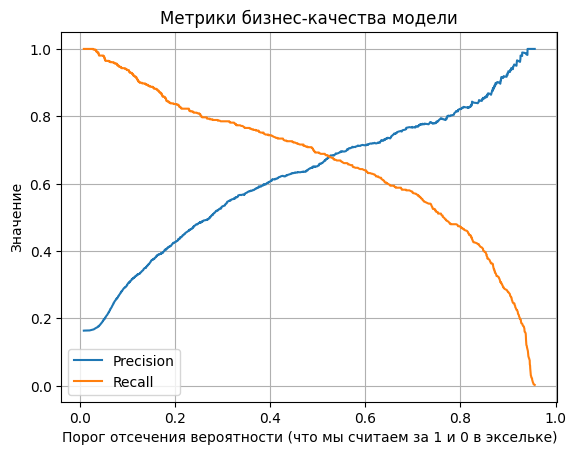

In [445]:
plt.plot(thresholds, precisions[:-1], thresholds, recalls[:-1])
plt.title("Метрики бизнес-качества модели")
plt.xlabel('Порог отсечения вероятности (что мы считаем за 1 и 0 в эксельке)')
plt.ylabel('Значение')
plt.legend(["Precision", "Recall"])
plt.grid()

Text(0.5, 1.0, '2-class Precision-Recall curve: AUC=0.74')

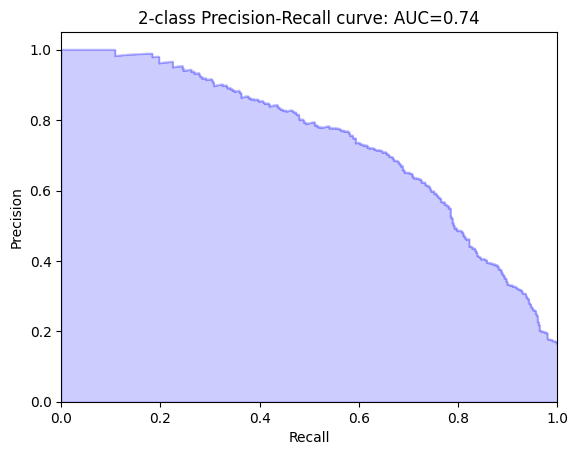

In [446]:
from inspect import signature

precisions, recalls, _ = precision_recall_curve(y_validation, model.predict_proba(X_validation)[:, 1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recalls, precisions, color='b', alpha=0.2,
         where='post')
plt.fill_between(recalls, precisions, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          auc(recalls, precisions)))

## 3.5 Оценка качества предсказания на X_validation

In [447]:
flag_is_churn = model.predict(X_validation)
flag_is_churn_probe = model.predict_proba(X_validation)[:,1]

In [448]:
X_validation['flag_is_churn_old'] = y_validation
X_validation['flag_is_churn'] = flag_is_churn
X_validation['flag_is_churn_probe'] = flag_is_churn_probe
X_validation['flag_is_churn75'] = np.where(X_validation['flag_is_churn_probe'] >= 0.75, 1, 0)
X_validation['flag_is_churn85'] = np.where(X_validation['flag_is_churn_probe'] >= 0.85, 1, 0)
X_validation['flag_is_churn_true'] = np.where((X_validation['flag_is_churn'] == 1) &  (X_validation['flag_is_churn_old'] == 1), 1, 0)
X_validation['flag_is_churn_true75'] = np.where((X_validation['flag_is_churn75'] == 1) & (X_validation['flag_is_churn_old'] == 1), 1, 0)
X_validation['flag_is_churn_true85'] = np.where((X_validation['flag_is_churn85'] == 1) & (X_validation['flag_is_churn_old'] == 1), 1, 0)

In [449]:
print(f'Правильных flag_is_churn: {X_validation.flag_is_churn_old.sum()}')
print(f'Предсказали: {X_validation.flag_is_churn.sum()}, угадали в {X_validation.flag_is_churn_true.sum()}, % попаданий {X_validation.flag_is_churn_true.sum() * 100 / X_validation.flag_is_churn.sum() }')
print(f'Предсказали с качеством 75%: {X_validation.flag_is_churn75.sum()}, угадали в {X_validation.flag_is_churn_true75.sum()}, % попаданий {X_validation.flag_is_churn_true75.sum() * 100 / X_validation.flag_is_churn75.sum() }')
print(f'Предсказали с качеством 85%: {X_validation.flag_is_churn85.sum()}, угадали в {X_validation.flag_is_churn_true85.sum()}, % попаданий {X_validation.flag_is_churn_true85.sum() * 100 / X_validation.flag_is_churn85.sum() }')

Правильных flag_is_churn: 507
Предсказали: 537, угадали в 351, % попаданий 65.36312849162012
Предсказали с качеством 75%: 333, угадали в 261, % попаданий 78.37837837837837
Предсказали с качеством 85%: 236, угадали в 202, % попаданий 85.59322033898304


In [450]:
x_validation_subs_plan_sales = X_validation.groupby(['subs_plan_sales']).sum()
x_validation_subs_plan_sales

C:\Users\a.zdanov\AppData\Local\Temp\ipykernel_20192\2530538004.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x_validation_subs_plan_sales = X_validation.groupby(['subs_plan_sales']).sum()


check_range  lt_to_apply  w1_user_cnt  w1_day_cnt  \
subs_plan_sales                                                      
Professional          426086       910829        54264        6793   
Standard              823650      1521470        29966       12107   

                 w2_user_cnt  w2_day_cnt  w3_user_cnt  w3_day_cnt  \
subs_plan_sales                                                     
Professional           53941        6722        53976        6777   
Standard               29701       11957        29784       12129   

                 w4_user_cnt  w4_day_cnt  w5_user_cnt  w5_day_cnt  \
subs_plan_sales                                                     
Professional           54048        6754        53670        6790   
Standard               29732       12081        29533       12068   

                 w6_user_cnt  w6_day_cnt  w7_user_cnt  w7_day_cnt  \
subs_plan_sales                                                     
Professional           53863        6806        53744        6806   
Standard               29621       12053        29516       12113   

                 w8_user_cnt  w8_day_cnt  w1_hit_per_user_cnt  \
subs_plan_sales                                                 
Professional           53391        6843              1415546   
Standard               29586       12189              2423577   

                 w2_hit_per_user_cnt  w3_hit_per_user_cnt  \
subs_plan_sales                                             
Professional                 1293671              1401376   
Standard                     2241313              2366211   

                 w4_hit_per_user_cnt  w5_hit_per_user_cnt  \
subs_plan_sales                                             
Professional                 1373396              1341754   
Standard                     2356537              2305587   

                 w6_hit_per_user_cnt  w7_hit_per_user_cnt  \
subs_plan_sales                                             
Professional                 1309135              1312197   
Standard                     2322056              2278048   

                 w8_hit_per_user_cnt  flag_is_churn_old  flag_is_churn  \
subs_plan_sales                                                          
Professional                 1318702                137            134   
Standard                     2348357                370            403   

                 flag_is_churn_probe  flag_is_churn75  flag_is_churn85  \
subs_plan_sales                                                          
Professional              203.686011               86               59   
Standard                  530.721873              247              177   

                 flag_is_churn_true  flag_is_churn_true75  \
subs_plan_sales                                             
Professional                     88                    69   
Standard                        263                   192   

                 flag_is_churn_true85  
subs_plan_sales                        
Professional                       50  
Standard                          152

In [451]:
x_validation_subs_plan_sales['flag_is_churn_true'] / x_validation_subs_plan_sales['flag_is_churn'] 

subs_plan_sales
Professional    0.656716
Standard        0.652605
dtype: float64

In [452]:
x_validation_buyer_status_mrr = X_validation.groupby(['buyer_status_mrr']).sum()
x_validation_buyer_status_mrr

C:\Users\a.zdanov\AppData\Local\Temp\ipykernel_20192\2741294267.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x_validation_buyer_status_mrr = X_validation.groupby(['buyer_status_mrr']).sum()


check_range  lt_to_apply  w1_user_cnt  w1_day_cnt  \
buyer_status_mrr                                                      
Fresh                  172280         3851         6402        2159   
New                    103994        66151         3748        1382   
Renewal                949007      2309388        73119       15015   
Returning               24455        52909          961         344   

                  w2_user_cnt  w2_day_cnt  w3_user_cnt  w3_day_cnt  \
buyer_status_mrr                                                     
Fresh                    6241        2139         6218        2156   
New                      3755        1370         3704        1404   
Renewal                 72694       14829        72894       15011   
Returning                 952         341          944         335   

                  w4_user_cnt  w4_day_cnt  w5_user_cnt  w5_day_cnt  \
buyer_status_mrr                                                     
Fresh                    6319        2138         6306        2132   
New                      3693        1393         3565        1382   
Renewal                 72796       14978        72392       14994   
Returning                 972         326          940         350   

                  w6_user_cnt  w6_day_cnt  w7_user_cnt  w7_day_cnt  \
buyer_status_mrr                                                     
Fresh                    6308        2121         6265        2147   
New                      3622        1389         3606        1404   
Renewal                 72531       15005        72410       15022   
Returning                1023         344          979         346   

                  w8_user_cnt  w8_day_cnt  w1_hit_per_user_cnt  \
buyer_status_mrr                                                 
Fresh                    6184        2191               417034   
New                      3608        1427               200504   
Renewal                 72218       15062              3189842   
Returning                 967         352                31743   

                  w2_hit_per_user_cnt  w3_hit_per_user_cnt  \
buyer_status_mrr                                             
Fresh                          391993               372127   
New                            176077               194763   
Renewal                       2941467              3171965   
Returning                       25447                28732   

                  w4_hit_per_user_cnt  w5_hit_per_user_cnt  \
buyer_status_mrr                                             
Fresh                          374827               361014   
New                            183674               181750   
Renewal                       3146258              3077108   
Returning                       25174                27469   

                  w6_hit_per_user_cnt  w7_hit_per_user_cnt  \
buyer_status_mrr                                             
Fresh                          357996               348504   
New                            198704               191714   
Renewal                       3046299              3021171   
Returning                       28192                28856   

                  w8_hit_per_user_cnt  flag_is_churn_old  flag_is_churn  \
buyer_status_mrr                                                          
Fresh                          416832                157            190   
New                            192197                 80             87   
Renewal                       3031162                254            234   
Returning                       26868                 16             26   

                  flag_is_churn_probe  flag_is_churn75  flag_is_churn85  \
buyer_status_mrr                                                          
Fresh                      194.650748              145              115   
New                         99.438711               55               42   
Renewal                    413.700672              119       

In [453]:
x_validation_buyer_status_mrr['flag_is_churn_true'] / x_validation_buyer_status_mrr['flag_is_churn'] 

buyer_status_mrr
Fresh        0.731579
New          0.735632
Renewal      0.581197
Returning    0.461538
dtype: float64

In [454]:
x_validation_check_channel = X_validation.groupby(['check_channel']).sum()
x_validation_check_channel

C:\Users\a.zdanov\AppData\Local\Temp\ipykernel_20192\3412530672.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x_validation_check_channel = X_validation.groupby(['check_channel']).sum()


check_range  lt_to_apply  w1_user_cnt  w1_day_cnt  w2_user_cnt  \
check_channel                                                                   
partner             986871      1922743        67432       14807        66984   
site                262865       509556        16798        4093        16658   

               w2_day_cnt  w3_user_cnt  w3_day_cnt  w4_user_cnt  w4_day_cnt  \
check_channel                                                                 
partner             14645        67247       14829        67246       14777   
site                 4034        16513        4077        16534        4058   

               w5_user_cnt  w5_day_cnt  w6_user_cnt  w6_day_cnt  w7_user_cnt  \
check_channel                                                                  
partner              66678       14752        66865       14774        66818   
site                 16525        4106        16619        4085        16442   

               w7_day_cnt  w8_user_cnt  w8_day_cnt  w1_hit_per_user_cnt  \
check_channel                                                             
partner             14818        66592       14940              3113511   
site                 4101        16385        4092               725612   

               w2_hit_per_user_cnt  w3_hit_per_user_cnt  w4_hit_per_user_cnt  \
check_channel                                                                  
partner                    2865720              3102196              3046006   
site                        669264               665391               683927   

               w5_hit_per_user_cnt  w6_hit_per_user_cnt  w7_hit_per_user_cnt  \
check_channel                                                                  
partner                    2995266              2976806              2951863   
site                        652075               654385               638382   

               w8_hit_per_user_cnt  flag_is_churn_old  flag_is_churn  \
check_channel                                                          
partner                    2949833                414            441   
site                        717226                 93             96   

               flag_is_churn_probe  flag_is_churn75  flag_is_churn85  \
check_channel                                                          
partner                 588.493268              280              203   
site                    145.914616               53               33   

               flag_is_churn_true  flag_is_churn_true75  flag_is_churn_true85  
check_channel                                                                  
partner                       292                   221                   172  
site                           59                    40                    30

In [455]:
x_validation_check_channel['flag_is_churn_true'] / x_validation_check_channel['flag_is_churn'] 

check_channel
partner    0.662132
site       0.614583
dtype: float64

## 4 Подготовим test_df

In [456]:
test_df = df_checks.copy()
#test_df = test_df.query('check_channel == "partner"')

In [457]:
test_df.head()

db_name db_apply_date   end_date subs_plan_sales  \
check_id                                                       
10465566   b9114649    2021-02-02 2022-02-14    Professional   
13157754  b13768882    2022-06-28 2023-07-06        Standard   
14416726  b13808764    2023-02-07 2024-05-12    Professional   
13114006  b21590094    2022-06-20 2023-06-20        Standard   
12062172  b19815424    2021-12-13 2022-12-13        Standard   

          check_number_by_portal  check_range billing_region  lt_to_apply  \
check_id                                                                    
10465566                     3.0          377             RU          783   
13157754                     3.0          373             RU          796   
14416726                     6.0          460             RU         1016   
13114006                     1.0          365             RU           26   
12062172                     1.0          365             RU            0   

         check_channel  partner_id buyer_status_mrr  period  w1_user_cnt  \
check_id                                                                   
10465566       partner     7847719          Renewal      12           79   
13157754       partner     9449029          Renewal      12           27   
14416726       partner     6745209          Renewal      12            9   
13114006       partner     1197701          Renewal      12           11   
12062172       partner     9472009            Fresh      12            0   

          w1_day_cnt  w2_user_cnt  w2_day_cnt  w3_user_cnt  w3_day_cnt  \
check_id                                                                 
10465566           7           83           6           87           7   
13157754           7           25           7           25           7   
14416726           7            8           7            9           7   
13114006           5           12           5           10           5   
12062172           0            0           0            0           0   

          w4_user_cnt  w4_day_cnt  w5_user_cnt  w5_day_cnt  w6_user_cnt  \
check_id                                                                  
10465566           81           7           79           7           80   
13157754           31           7           32           7           26   
14416726           10           7            8           7            8   
13114006           11           6           11           5           13   
12062172            0           0            1           2            0   

          w6_day_cnt  w7_user_cnt  w7_day_cnt  w8_user_cnt  w8_day_cnt  \
check_id                                                                 
10465566           7           57           7           80           7   
13157754           7           17           7           24           7   
14416726           7           10           7           10           7   
13114006           5           13           6           14           5   
12062172           0            0           0            0           0   

          w1_hit_per_user_cnt  w2_hit_per_user_cnt  w3_hit_per_user_cnt  \
check_id                                                                  
10465566           660.455696           572.987952           890.735632   
13157754          1808.074074          1685.960000          1638.720000   
14416726          2943.888889          2799.375000          3204.000000   
13114006          1143.181818          1078.750000          1292.200000   
12062172             0.000000             0.000000             0.000000   

          w4_hit_per_user_cnt  w5_hit_per_user_cnt  w6_hit_per_user_cnt  \
check_id                                                                  
10465566           698.358025           588.772152           548.937500   
13157754          1283.870968          1286.593750          1494.153846   
14416726          2619.100000          2916.875000          2523.125000   
13114006          1327.90

In [458]:
# для предсказания мы берем последний период + последние чеки, нам и нужно узнать будет ли по ним продление
test_df = test_df.query('db_apply_date >= "2022-11-01" and db_apply_date <= "2022-12-31"').query('flag_is_churn == 1')
print(test_df.end_date.min(), test_df.end_date.max())

2023-07-13 00:00:00 2026-04-15 00:00:00


In [459]:
test_df.shape

(4087, 37)

In [460]:
test_df = test_df.drop([
                         'db_apply_date', 'end_date'
], axis=1)

In [461]:
test_df.head()

db_name subs_plan_sales  check_number_by_portal  check_range  \
check_id                                                                   
13997384  b17350968    Professional                     3.0          377   
14049564  b23438298    Professional                     1.0          365   
13885104  b22230666    Professional                     2.0          366   
13861018  b23160790        Standard                     2.0          377   
14162344  b16134214    Professional                     3.0          365   

         billing_region  lt_to_apply check_channel  partner_id  \
check_id                                                         
13997384             RU          591          site           0   
14049564             RU           29       partner     1568789   
13885104             RU          104          site           0   
13861018             RU           19          site           0   
14162344             RU          755       partner    17003102   

         buyer_status_mrr  period  w1_user_cnt  w1_day_cnt  w2_user_cnt  \
check_id                                                                  
13997384          Renewal      12           10           7            8   
14049564          Renewal      12            3           4            0   
13885104          Renewal      12           18           7           17   
13861018          Renewal      12            7           7            7   
14162344          Renewal      12            2           2            1   

          w2_day_cnt  w3_user_cnt  w3_day_cnt  w4_user_cnt  w4_day_cnt  \
check_id                                                                 
13997384           6            8           7            9           7   
14049564           0            0           0            0           0   
13885104           7           17           7           14           7   
13861018           6            7           7            8           7   
14162344           4            2           6            1           4   

          w5_user_cnt  w5_day_cnt  w6_user_cnt  w6_day_cnt  w7_user_cnt  \
check_id                                                                  
13997384            9           7            9           7           10   
14049564            0           0            0           0            0   
13885104           15           7           16           7           14   
13861018            7           2            0           0            0   
14162344            1           4            2           7            1   

          w7_day_cnt  w8_user_cnt  w8_day_cnt  w1_hit_per_user_cnt  \
check_id                                                             
13997384           7            8           6           859.100000   
14049564           0            0           0           140.666667   
13885104           7           14           7           678.055556   
13861018           0            0           0          3940.571429   
14162344           5            3           6            33.000000   

          w2_hit_per_user_cnt  w3_hit_per_user_cnt  w4_hit_per_user_cnt  \
check_id                                                                  
13997384           924.750000           992.750000           956.333333   
14049564             0.000000             0.000000             0.000000   
13885104           651.588235          1288.117647           405.285714   
13861018          3087.142857           423.714286           807.750000   
14162344           241.000000            66.500000           642.000000   

          w5_hit_per_user_cnt  w6_hit_per_user_cnt  w7_hit_per_user_cnt  \
check_id                                                                  
13997384           970.888889          1413.555556           984.700000   
14049564             0.000000             0.000000             0.000000   
13885104           449.066667           277.437500           245.071429   
13861018           248.857143             0.000000   

In [462]:
test_df = test_df.astype({
                            "flag_is_churn":int,
                            "w1_hit_per_user_cnt":int,
                            "w2_hit_per_user_cnt":int,
                            "w3_hit_per_user_cnt":int,
                            "w4_hit_per_user_cnt":int,
                            "w5_hit_per_user_cnt":int,
                            "w6_hit_per_user_cnt":int,
                            "w7_hit_per_user_cnt":int,
                            "w8_hit_per_user_cnt":int,
                            "check_number_by_portal":str,
                            "partner_id":str,
                            "period":str,
                           }) 

In [464]:
test_df.head().T

check_id                    13997384      14049564      13885104   13861018  \
db_name                    b17350968     b23438298     b22230666  b23160790   
subs_plan_sales         Professional  Professional  Professional   Standard   
check_number_by_portal           3.0           1.0           2.0        2.0   
check_range                      377           365           366        377   
billing_region                    RU            RU            RU         RU   
lt_to_apply                      591            29           104         19   
check_channel                   site       partner          site       site   
partner_id                         0       1568789             0          0   
buyer_status_mrr             Renewal       Renewal       Renewal    Renewal   
period                            12            12            12         12   
w1_user_cnt                       10             3            18          7   
w1_day_cnt                         7             4             7          7   
w2_user_cnt                        8             0            17          7   
w2_day_cnt                         6             0             7          6   
w3_user_cnt                        8             0            17          7   
w3_day_cnt                         7             0             7          7   
w4_user_cnt                        9             0            14          8   
w4_day_cnt                         7             0             7          7   
w5_user_cnt                        9             0            15          7   
w5_day_cnt                         7             0             7          2   
w6_user_cnt                        9             0            16          0   
w6_day_cnt                         7             0             7          0   
w7_user_cnt                       10             0            14          0   
w7_day_cnt                         7             0             7          0   
w8_user_cnt                        8             0            14          0   
w8_day_cnt                         6             0             7          0   
w1_hit_per_user_cnt              859           140           678       3940   
w2_hit_per_user_cnt              924             0           651       3087   
w3_hit_per_user_cnt              992             0          1288        423   
w4_hit_per_user_cnt              956             0           405        807   
w5_hit_per_user_cnt              970             0           449        248   
w6_hit_per_user_cnt             1413             0           277          0   
w7_hit_per_user_cnt              984             0           245          0   
w8_hit_per_user_cnt              774             0           372          0   
flag_is_churn                      1             1             1          1   

check_id                    14162344  
db_name                    b16134214  
subs_plan_sales         Professional  
check_number_by_portal           3.0  
check_range                      365  
billing_region                    RU  
lt_to_apply                      755  
check_channel                partner  
partner_id                  17003102  
buyer_status_mrr             Renewal  
period                            12  
w1_user_cnt                        2  
w1_day_cnt                         2  
w2_user_cnt                        1  
w2_day_cnt                         4  
w3_user_cnt                        2  
w3_day_cnt                         6  
w4_user_cnt                        1  
w4_day_cnt                         4  
w5_user_cnt                        1  
w5_day_cnt                         4  
w6_user_cnt                        2  
w6_day_cnt                         7  
w7_user_cnt                        1  
w7_day_cnt                         5  
w8_user_cnt                        3  
w8_day_cnt                         6  
w1_hit_per_user_cnt               33  
w2_hit_per_user_cnt              241  
w3_hit_per_user_cnt     

In [465]:
test_df.flag_is_churn.value_counts()

1    4087
Name: flag_is_churn, dtype: int64

In [466]:
#Preparing your data
y_test = test_df.flag_is_churn
y_db_name = test_df.db_name
X_test = test_df.drop(columns=['flag_is_churn', 'db_name'], axis=1)

### Model Applying

In [467]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)

In [468]:
df_pred = pd.DataFrame()
df_pred['flag_is_churn_old'] = y_test
df_pred['flag_is_churn'] = model.predict(X_test)
df_pred['flag_is_churn_probe'] = model.predict_proba(X_test)[:,1]
df_pred['flag_is_churn75'] = np.where(df_pred['flag_is_churn_probe'] >= 0.75, 1, 0)
df_pred['flag_is_churn80'] = np.where(df_pred['flag_is_churn_probe'] >= 0.80, 1, 0)
df_pred['flag_is_churn_old'] = y_test
df_pred['db_name'] = y_db_name

In [469]:
df_pred

flag_is_churn_old  flag_is_churn  flag_is_churn_probe  \
check_id                                                          
13997384                  1              0             0.070110   
14049564                  1              1             0.810977   
13885104                  1              0             0.099346   
13861018                  1              0             0.103489   
14162344                  1              1             0.629081   
...                     ...            ...                  ...   
14098272                  1              0             0.143605   
14184696                  1              0             0.135239   
14041292                  1              0             0.395400   
14090640                  1              0             0.054348   
14094292                  1              0             0.056816   

          flag_is_churn75  flag_is_churn80    db_name  
check_id                                               
13997384                0                0  b17350968  
14049564                1                1  b23438298  
13885104                0                0  b22230666  
13861018                0                0  b23160790  
14162344                0                0  b16134214  
...                   ...              ...        ...  
14098272                0                0  b20057992  
14184696                0                0   b2003943  
14041292                0                0  b23113442  
14090640                0                0  b19818686  
14094292                0                0   b3146467  

[4087 rows x 6 columns]

In [470]:
print(df_pred.flag_is_churn_old.sum(), df_pred.flag_is_churn.sum(), df_pred.flag_is_churn75.sum(), 
      df_pred.flag_is_churn80.sum())

4087 1055 843 785


In [471]:
print(df_pred.flag_is_churn_old.sum() * 100 / df_pred.shape[0])
print(df_pred.flag_is_churn.sum() * 100 / df_pred.shape[0])
print(df_pred.flag_is_churn75.sum() * 100 / df_pred.shape[0])
print(df_pred.flag_is_churn80.sum() * 100 / df_pred.shape[0])

100.0
25.81355517494495
20.626376315145585
19.207242476143872


In [472]:
df_pred = df_pred.reset_index()

In [473]:
df_result = df_pred.copy()

In [474]:
df_result = df_result.drop([
                             'flag_is_churn_old', 'flag_is_churn','flag_is_churn75', 'flag_is_churn80'
                                                                    ], axis=1)

In [476]:
df_result['date_predict'] = '2023-03-01'

In [477]:
df_result = df_result.rename(columns={"flag_is_churn_probe": "proba"})

In [478]:
df_result

check_id     proba    db_name date_predict
0     13997384  0.070110  b17350968   2023-03-01
1     14049564  0.810977  b23438298   2023-03-01
2     13885104  0.099346  b22230666   2023-03-01
3     13861018  0.103489  b23160790   2023-03-01
4     14162344  0.629081  b16134214   2023-03-01
...        ...       ...        ...          ...
4082  14098272  0.143605  b20057992   2023-03-01
4083  14184696  0.135239   b2003943   2023-03-01
4084  14041292  0.395400  b23113442   2023-03-01
4085  14090640  0.054348  b19818686   2023-03-01
4086  14094292  0.056816   b3146467   2023-03-01

[4087 rows x 4 columns]